### Notebook to analyse the results of HS detection on new independant cohort 

In [33]:
import os
import pandas as pd
import numpy as np
import glob


In [34]:
folder = '/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_H10/aidhs_data_folder'

In [35]:
#sites
sites = ['H10','H21','H102','H2']

#load subjects list
subjects = []
for site in sites:
    subjects_file  = os.path.join(folder, f'list_subjects_{site}.csv')
    subjects_site = pd.read_csv(subjects_file)['ID'].values
    subjects.extend(subjects_site)
len(subjects)

180

In [36]:
#load demographic group for harmonisation
demos_file  = os.path.join(folder,'demographics_file.csv')

df_demos = pd.read_csv(demos_file)
df_demos.head()

,ID,Site,Scanner,"Patient or Control (Patient = 1, Control = 0)",Age at preoperative,"Sex (Female = 1, Male = 0)"
0,MELD_H2_P_0002,H2,3T,1,13.0,1
1,MELD_H2_P_0024,H2,3T,1,4.5,0
2,MELD_H2_P_0035,H2,3T,1,16.3,1
3,MELD_H2_C_0002,H2,3T,0,9.3,1
4,MELD_H2_C_0003,H2,3T,0,7.6,0


In [40]:
# load csv with more information
df_info = pd.DataFrame()
for site in sites:
    info_file = glob.glob(os.path.join(folder,f'MELD_participants_infos_{site}_*.csv'))[0]

    df_info_site = pd.read_csv(info_file)
    df_info = pd.concat([df_info,df_info_site])
df_info.head()

,Unnamed: 0,id,old_id,included,reason exlusion,redcap_data_access_group,site,patient_control,sex,radiology,...,aeds_post_op,participant_information_complete,hemi,reason exclusion,reason_exclusion,field_strengths___unk,field_strengths___na,postop_t1_yr_2___unk,postop_t1_yr_2___na,Unnamed: 1
0,1.0,MELD_H10_P_0001,RMKFDO,1,NaN,NaN,H10,1,0,1.0,...,1.0,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,MELD_H10_P_0002,ARM,1,NaN,NaN,H10,1,1,8.0,...,1.0,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,MELD_H10_P_0003,ELR,1,NaN,NaN,H10,1,0,8.0,...,1.0,NaN,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,MELD_H10_P_0004,AAO,1,NaN,NaN,H10,1,1,10.0,...,1.0,NaN,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,MELD_H10_P_0005,ADT,1,NaN,NaN,H10,1,1,10.0,...,1.0,NaN,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

results_folder = '/home/mathilde/Documents/projects/surHippo/processes/240404_AID-HS_H10/aidhs_data_folder/output/prediction_reports'

df_data = pd.DataFrame()

group_array = []
predictions_array = []
labels_array = []
scores_array = []


for subject in subjects:
    print(subject)
    values={}
    values['id'] = subject
    group = df_demos[df_demos['ID']==subject]['Patient or Control (Patient = 1, Control = 0)'].values[0]
    if group == 1:
        group = 'P'
        hemi = df_info[df_info['id']==subject]['hemi'].values[0]
        if hemi=='L':
            label = 'left HS'
        elif hemi=='R':
            label = 'right HS'
        else:
            print('Hemisphere not known')
    else:
        label = 'no asymmetry'
        group = 'C'
    values['label'] = label
    values['group'] = group
    
    df_results = pd.read_csv(os.path.join(results_folder, subject, f'{subject}_predictions.csv'))
    values['scores']= df_results[['score no asymmetry', 'score left HS', 'score right HS']].values[0]
    values['prediction'] = df_results['prediction'].values[0]

    df_data = pd.concat([df_data, pd.DataFrame([values])])
df_data = df_data.reset_index(drop=True)
df_data.head()

MELD_H10_P_0004
MELD_H10_P_0005
MELD_H10_P_0006
MELD_H10_P_0007
MELD_H10_P_0008
MELD_H10_P_0009
MELD_H10_P_0010
MELD_H10_P_0011
MELD_H10_P_0013
MELD_H10_P_0014
MELD_H10_P_0015
MELD_H10_P_0016
MELD_H10_P_0017
MELD_H10_P_0018
MELD_H10_P_0019
MELD_H10_P_0020
MELD_H10_P_0021
MELD_H10_P_0022
MELD_H10_P_0023
MELD_H10_P_0024
MELD_H10_P_0025
MELD_H10_P_0026
MELD_H10_P_0027
MELD_H10_P_0028
MELD_H10_P_0029
MELD_H10_P_0030
MELD_H10_P_0031
MELD_H10_P_0032
MELD_H10_P_0033
MELD_H10_P_0034
MELD_H10_P_0035
MELD_H10_P_0036
MELD_H10_P_0037
MELD_H10_P_0038
MELD_H10_P_0039
MELD_H10_P_0040
MELD_H10_P_0041
MELD_H10_P_0042
MELD_H10_P_0043
MELD_H10_P_0044
MELD_H10_P_0045
MELD_H10_P_0046
MELD_H10_P_0047
MELD_H10_P_0049
MELD_H10_P_0050
MELD_H10_P_0051
MELD_H10_P_0052
MELD_H10_P_0053
MELD_H10_P_0054
MELD_H10_P_0055
MELD_H10_P_0056
MELD_H10_P_0057
MELD_H10_P_0058
MELD_H10_P_0059
MELD_H10_C_0001
MELD_H10_C_0002
MELD_H10_C_0003
MELD_H10_C_0004
MELD_H10_C_0005
MELD_H10_C_0006
MELD_H10_C_0007
MELD_H10_C_0008
MELD_H10

,id,label,group,scores,prediction
0,MELD_H10_P_0004,left HS,P,"[0.0064509406983215, 0.9935489932248908, 6.607...",left HS
1,MELD_H10_P_0005,left HS,P,"[4.574469503575679e-07, 0.9999995425530496, 3....",left HS
2,MELD_H10_P_0006,right HS,P,"[0.0561777797919347, 0.0001006592567786, 0.943...",right HS
3,MELD_H10_P_0007,right HS,P,"[0.0002296615060225, 2.965491848758717e-09, 0....",right HS
4,MELD_H10_P_0008,left HS,P,"[0.0016685435092738, 0.9983314564736898, 1.703...",left HS


In [69]:
# Encode data class and prediction
import numpy as np
from sklearn.preprocessing import label_binarize

dict_labels = {'no asymmetry':0,
               'left HS':1,
               'right HS':2}
Y = np.array([dict_labels[x] for x in df_data['label'].values])
y_pred = np.array([dict_labels[x] for x in df_data['prediction'].values])
scores =  np.array([x for x in df_data['scores']])

#Binarize the output
y_bin = label_binarize(Y, classes=np.arange(len(set(Y))))

print('number ipsi lh: ' + str(len(np.where(Y==1)[0])))
print('number ipsi rh: ' + str(len(np.where(Y==2)[0])))
print('number control: ' + str(len(np.where(Y==0)[0])))


number ipsi lh: 36
number ipsi rh: 29
number control: 115


In [70]:
# compute results lateralisation and detection
from aidhs.train_evaluate import compute_performances, get_lateralisation_performances, get_differentiation_performances

#COMPUTE PERFORMANCES
results = compute_performances(Y, y_bin, y_pred, scores)
    
#add lateralisation performances
results['predict_side'], results['accurately_lateralised'], results['scores_lateralised'] = get_lateralisation_performances(Y, scores)

#add detection performances
results['predict_group'], results['accurately_differentiated'], results['scores_differentiated'] = get_differentiation_performances(Y, scores)
    

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       115
           1       0.83      0.83      0.83        36
           2       0.85      0.97      0.90        29

    accuracy                           0.90       180
   macro avg       0.87      0.90      0.89       180
weighted avg       0.90      0.90      0.90       180



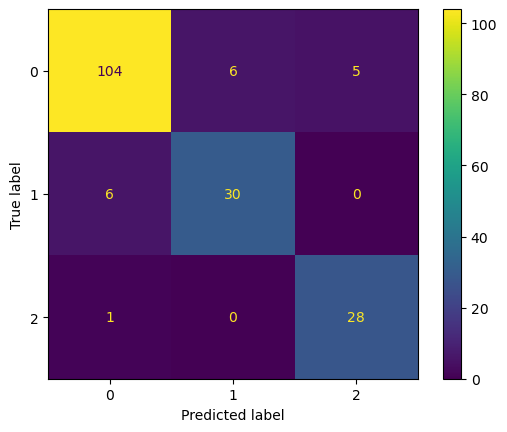

In [71]:
# plot confusion matrix
print(classification_report(Y,results['predictions']))
cm = confusion_matrix(Y,results['predictions'])
ConfusionMatrixDisplay(cm).plot()

In [72]:
#comparison of overall performances per methods

try:
    print('\nPerformances lateralisation only:')
    df_data[f'TP_side'] = results['accurately_lateralised']
    
    n_tot = len(df_data[(df_data['group']=='P')])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['TP_side']==True)])
        print(f'TP in HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

except:
    pass

try:
    print('\nPerformances differentiation only:')
    df_data[f'TP_group'] = results['accurately_differentiated']

    n_tot = len(df_data)
    if n_tot>0:
        n_tp = len(df_data[(df_data['TP_group']==True)])
        print(f'TP differentiating: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    n_tot = len(df_data[df_data['group']!='P'])
    if n_tot>0:
        n_tp = len(df_data[(df_data['group']!='P')&(df_data['TP_group']==True)])
        print(f'TP detecting controls: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')

    n_tot = len(df_data[(df_data['group']=='P')])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['TP_group']==True)])
        print(f'TP detecting HS: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')
except:
    pass


Performances lateralisation only:
TP in HS: 64/65 (98.5%)

Performances differentiation only:
TP differentiating: 162/180 (90.0%)
TP detecting controls: 104/115 (90.4%)
TP detecting HS: 58/65 (89.2%)


In [78]:
# find results 
detected = np.array(predictions_array)==np.array(labels_array)

subjects_fp = subjects[detected==False]

subjects_fp

In [76]:
#breakdown per site

#combine df_data with site
df_data['site'] = [df_info[df_info['id']==subject]['site'].values[0] for subject in df_data['id']]

#print performances per site
print('\nPerformances lateralisation only:')
df_data[f'TP_side'] = results['accurately_lateralised']
for site in sites:
    n_tot = len(df_data[(df_data['group']=='P')&(df_data['site']==site)])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['site']==site)&(df_data['TP_side']==True)])
        print(f'TP lateralising {site}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')


print('\nPerformances differentiation only:')
df_data[f'TP_group'] = results['accurately_differentiated']
        
for site in sites:
    n_tot = len(df_data[(df_data['group']=='P')&(df_data['site']==site)])
    if n_tot>0:   
        n_tp = len(df_data[(df_data['group']=='P')&(df_data['site']==site)&(df_data['TP_group']==True)])
        print(f'TP detecting {site}: {n_tp}/{n_tot} ({round(n_tp/n_tot*100,1)}%)')


Performances lateralisation only:
TP lateralising H10: 53/54 (98.1%)
TP lateralising H21: 3/3 (100.0%)
TP lateralising H102: 5/5 (100.0%)
TP lateralising H2: 3/3 (100.0%)

Performances differentiation only:
TP detecting H10: 49/54 (90.7%)
TP detecting H21: 2/3 (66.7%)
TP detecting H102: 4/5 (80.0%)
TP detecting H2: 3/3 (100.0%)


In [62]:
df_data

,id,label,group,scores,prediction,TP_side,TP_group
0,MELD_H10_P_0004,left HS,P,"[0.0064509406983215, 0.9935489932248908, 6.607...",left HS,True,True
0,MELD_H10_P_0005,left HS,P,"[4.574469503575679e-07, 0.9999995425530496, 3....",left HS,True,True
0,MELD_H10_P_0006,right HS,P,"[0.0561777797919347, 0.0001006592567786, 0.943...",right HS,True,True
0,MELD_H10_P_0007,right HS,P,"[0.0002296615060225, 2.965491848758717e-09, 0....",right HS,True,True
0,MELD_H10_P_0008,left HS,P,"[0.0016685435092738, 0.9983314564736898, 1.703...",left HS,True,True
...,...,...,...,...,...,...,...
0,MELD_H2_C_0017,no asymmetry,C,"[0.7756268811365519, 0.1425615579812995, 0.081...",no asymmetry,NaN,True
0,MELD_H2_C_0018,no asymmetry,C,"[0.8299096625149719, 0.0787531371875128, 0.091...",no asymmetry,NaN,True
0,MELD_H2_C_0019,no asymmetry,C,"[0.7910032538121587, 0.0846084400619603, 0.124...",no asymmetry,NaN,True
0,MELD_H2_C_0020,no asymmetry,C,"[0.6010358420699983, 0.3955441652371358, 0.003...",no asymmetry,NaN,True


In [35]:
df_info[df_info['id']=='MELD_H10_P_0045']

,Unnamed: 0,id,old_id,included,reason exlusion,redcap_data_access_group,site,patient_control,sex,radiology,...,seizure_free,seizure_free_aura,engel_1yr,ilae_1yr,engel,ilae,follow_up,aeds_post_op,participant_information_complete,hemi
44,45,MELD_H10_P_0045,NCF,1,NaN,NaN,H10,1,0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN,L
